In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
# import dask.dataframe as dd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy import stats
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm
import gc
from scipy.io import wavfile #convert dataframe to sound 
from IPython.core.display import HTML
from sklearn.metrics import mean_absolute_error
import librosa
from catboost import CatBoostRegressor,Pool

from sklearn.externals import joblib 

<h2>Importing the data after EDA and Feature Engineering </h2>

In [0]:
import pickle
with open('y_train', 'rb') as f:
    y_train = pickle.load(f)


with open('x_train', 'rb') as f:
    x_train = pickle.load(f)

with open('x_test', 'rb') as f:
    x_test = pickle.load(f)



<h3> Dividing the data into train and CV for cross validating the error <h3>

In [0]:
# Divide the data into cv and train
from sklearn.model_selection import train_test_split
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,test_size = 0.1,random_state= 42)


#LGBM

In [436]:
import lightgbm as lgb
params = {'num_leaves': 4, # Low number of leaves reduces LGBM complexity
          'min_data_in_leaf': 5,
          'objective':'fair', # Fitting to fair objective performed better than fitting to MAE objective
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt", 
          'boost_from_average': True,
          "feature_fraction": 0.9,
          "bagging_freq": 1,
          "bagging_fraction": 0.5,
          "bagging_seed": 0,
          "metric": 'mae',
          "verbosity": -1,
          'max_bin': 500,
          'reg_alpha': 0, 
          'reg_lambda': 0,
          'n_jobs': 1
          }
trn_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_train, label=y_train) # Validation is not running for more iteration hence have to keep x_train only here
lgbm_model = lgb.train(params, trn_data, 430,valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 1000)


Training until validation scores don't improve for 1000 rounds.
Did not meet early stopping. Best iteration is:
[430]	training's l1: 1.90933	valid_1's l1: 1.90933


In [0]:
cv_pred_lgb = lgbm_model.predict(x_cv)

In [246]:
cv_pred_lgb[:10]

array([ 2.07934204, 10.40320467,  6.94327691,  3.02479537,  2.56770003,
        7.28860105,  9.67783177,  6.83171589,  1.35346442,  4.48759473])

In [247]:
y_cv[:10].values

array([[ 1.37129712],
       [ 8.27259972],
       [ 8.60729916],
       [ 1.30829737],
       [ 1.47749618],
       [11.52579582],
       [ 9.97139798],
       [ 5.53919854],
       [ 1.8124981 ],
       [ 0.34519822]])

In [0]:
#check MAE for the CV by LGBM

y_cv_org = y_cv.values
y_cv_pred = cv_pred_lgb[:]

lgb_result_cv = []
for index in range(0,len(cv_pred_lgb)):
  lgb_result_cv.append((y_cv_pred[index] - y_cv_org[index]) * (y_cv_pred[index] - y_cv_org[index]))

sum_lgb_cv = sum(lgb_result_cv)
sum_lgb_cv_mean = sum_lgb_cv / len(cv_pred_lgb)



In [249]:
print(sum_lgb_cv_mean) # This is the MAE on CV data and it's looking good
# 6.01725782 at 512
# 6.00538636 at 500
#6.00431808 at 450
# 6.04327404 at 400
# 6.00064977 at 430
# 433 6.00587812

[6.00064977]


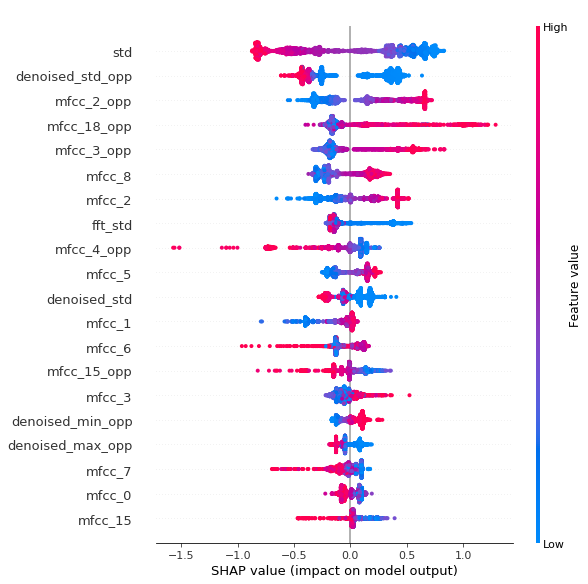

In [0]:

############# Most time taking function ############
##### Don't Run if less ram #########
import shap

explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train)

#CatModel

In [437]:
from catboost import CatBoostRegressor, Pool
cat_model = CatBoostRegressor(
            iterations=1200, learning_rate=0.018999, verbose=32, eval_metric='MAE', task_type='GPU')
# clf = CatBoostRegressor(n_estimators=8000, verbose=1000, objective="MAE", boosting_type="Ordered", task_type="GPU",learning_rate=0.04)

cat_model.fit(x_train,y_train)
#0.95 previously with 30k 

0:	learn: 3.0182080	total: 27.3ms	remaining: 32.7s
32:	learn: 2.4058942	total: 828ms	remaining: 29.3s
64:	learn: 2.1784222	total: 1.56s	remaining: 27.3s
96:	learn: 2.0891010	total: 2.28s	remaining: 26s
128:	learn: 2.0442392	total: 3s	remaining: 24.9s
160:	learn: 2.0170533	total: 3.71s	remaining: 24s
192:	learn: 1.9975570	total: 4.44s	remaining: 23.1s
224:	learn: 1.9817937	total: 5.15s	remaining: 22.3s
256:	learn: 1.9683053	total: 5.84s	remaining: 21.4s
288:	learn: 1.9567136	total: 6.54s	remaining: 20.6s
320:	learn: 1.9460469	total: 7.22s	remaining: 19.8s
352:	learn: 1.9364790	total: 7.92s	remaining: 19s
384:	learn: 1.9258085	total: 8.62s	remaining: 18.2s
416:	learn: 1.9167980	total: 9.35s	remaining: 17.6s
448:	learn: 1.9068044	total: 10s	remaining: 16.8s
480:	learn: 1.8972855	total: 10.7s	remaining: 16s
512:	learn: 1.8881666	total: 11.4s	remaining: 15.3s
544:	learn: 1.8783269	total: 12.1s	remaining: 14.5s
576:	learn: 1.8694957	total: 12.8s	remaining: 13.8s
608:	learn: 1.8599568	total: 

In [289]:
#Check MAE on CV using catBoost model
cv_pred_cat = cat_model.predict(x_cv)

cat_result_cv = []
for index in range(0,len(cv_pred_cat)):
  cat_result_cv.append((cv_pred_cat[index] - y_cv_org[index]) * (cv_pred_cat[index] - y_cv_org[index]))

sum_cat_cv = sum(cat_result_cv)

sum_cat_mean_cv = sum_cat_cv / len(cv_pred_cat)
print(sum_cat_mean_cv)
# at 512 5.9686735
# at 510 5.96824669
# at 511 5.96744135
# at 600 5.96284639 
# at 650 5.95921433 
# at 800 5.95560438
# at 1200 and learning 0.016  5.91783832 
# at 1200 and learning 0.017  5.90141135 
#at 1200 and learning 0.019  5.85995924 
# at 1200 at 0.018999 5.8362926 //least 
# at 1200 .020 5.92093588
# at 500 5.96865411
# at 430 6.00145801
# at 470 5.998312

[5.8362926]


In [0]:
#Merging both the models and checking the score on cv

In [0]:
cat_pred = cat_model.predict(x_cv)
lgbm_pred = lgbm_model.predict(x_cv)

cat_arr = []
for index in cat_pred:
  cat_arr.append(index)

lgbm_arr = []
for index in lgbm_pred:
  lgbm_arr.append(index)



In [0]:
res_list = [] 
for i in range(0, len(cat_arr)): 
    res_list.append((((cat_arr[i]) * 0.8) + ((lgbm_arr[i])* 0.2)))
  

In [73]:
#Check MAE on CV using both the models

cat_result_cv = []
for index in range(0,len(res_list)):
  cat_result_cv.append((res_list[index] - y_cv_org[index]) * (res_list[index] - y_cv_org[index]))

sum_cat_cv = sum(cat_result_cv)

sum_cat_mean_cv = sum_cat_cv / len(res_list)
print(sum_cat_mean_cv)

[5.96480534]


<b>importance from the catBoost using Shap values</b>

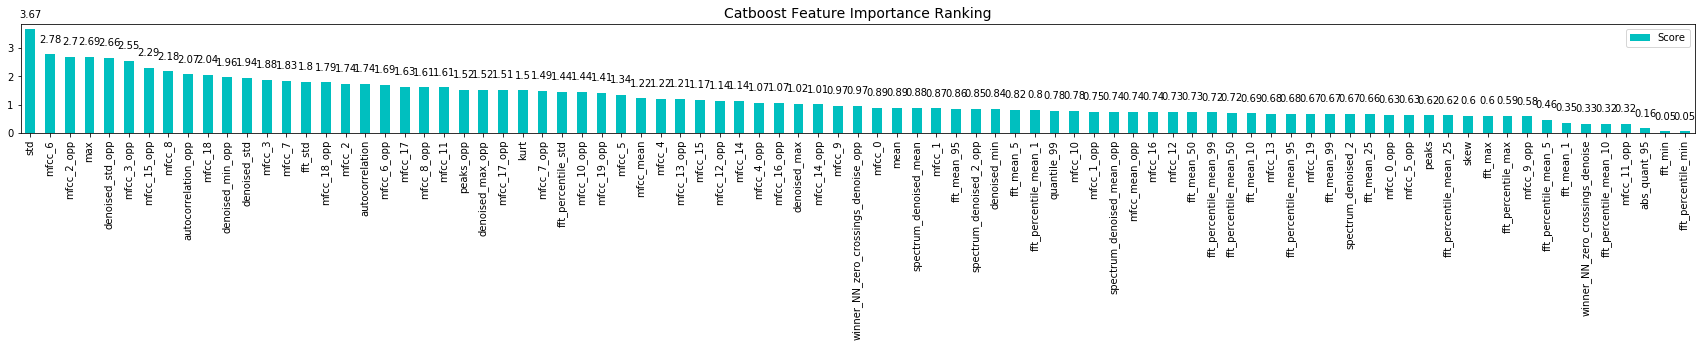

In [0]:
feature_score = pd.DataFrame(list(zip(x_train.dtypes.index, cat_model.get_feature_importance(Pool(x_train, label=y_train)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')


plt.rcParams["figure.figsize"] = (30,2)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

<b> check based on shap graph CAT
 <b>

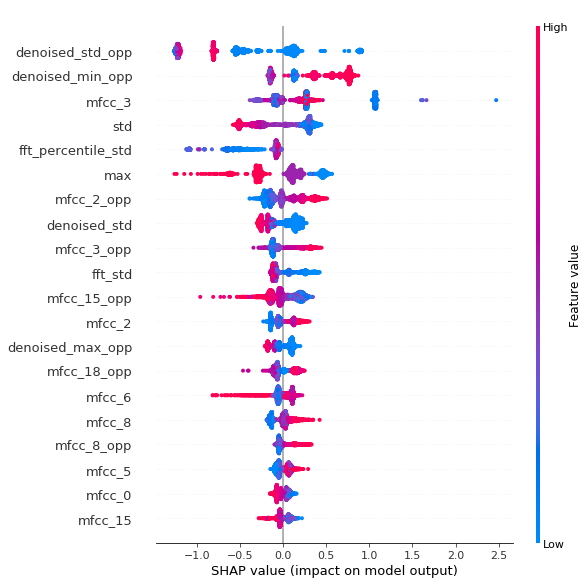

In [0]:
############# Most time taking function ############
##### Don't Run if less ram #########
import shap

explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train)

#Random Forest

In [0]:
# this not looking good we'll try by stacking another model 

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV

parameter_grid = {'n_estimators': [50,80,90],
                  'max_depth': [3,5,6,7]
                 }  

In [300]:

#random Forest
regr_grid = GridSearchCV(RandomForestRegressor(), param_grid=parameter_grid,n_jobs = -1,cv=10, return_train_score=True)
regr_grid.fit(x_train,y_train)
print(regr_grid.best_params_)

{'max_depth': 5, 'n_estimators': 80}


In [438]:
rf_model = RandomForestRegressor(max_depth=5, random_state=42,n_estimators=75)
rf_model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=75,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [342]:
regr_pred_cv = rf_model.predict(x_cv)

y_cv_org = y_cv.values
y_cv_pred = regr_pred_cv[:]

rf_result_cv = []
for index in range(0,len(y_cv_pred)):
  rf_result_cv.append((y_cv_pred[index] - y_cv_org[index]) * (y_cv_pred[index] - y_cv_org[index]))

sum_rf_cv = sum(rf_result_cv)
sum_rf_cv_mean = sum_rf_cv / len(y_cv_pred)
print(sum_rf_cv_mean)
# w/o max_depth and n_estimator 6.53059592
# at 5 and 80 depth 6.20147728'
#81 6.20312337
# 75 6.18789375
# at 85 6.20858538

[6.18789375]


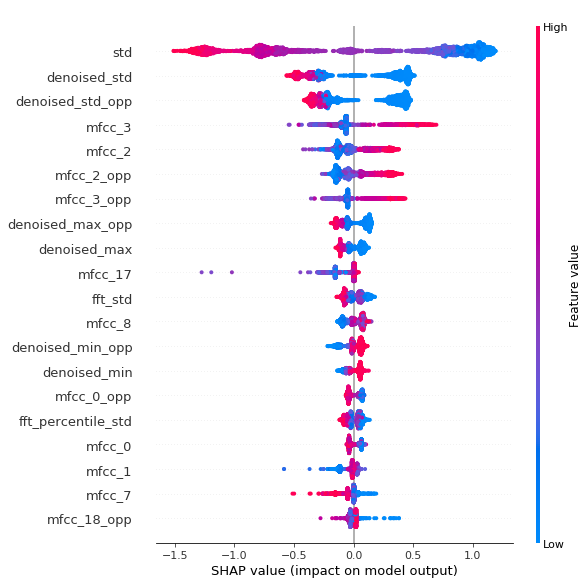

In [0]:

############# Most time taking function ############
##### Don't Run if less ram #########
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train)

# XGboost

In [343]:
from xgboost import XGBRegressor
parameter_grid = {'n_estimators': [50,60,70,80,90,100],
                  'max_depth': [2,3,5,6,7]
                 }  

xgb_grid = GridSearchCV(XGBRegressor(random_state=42), param_grid=parameter_grid,n_jobs = -1,cv=10, return_train_score=True)
xgb_grid.fit(x_train,y_train)
print(xgb_grid.best_params_)

[10:22:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'max_depth': 2, 'n_estimators': 50}


In [439]:
xgb_boost = XGBRegressor(max_depth=2, random_state=42,n_estimators=51)
xgb_boost.fit(x_train,y_train)

[12:21:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=51,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [359]:
xgb_pred_cv = xgb_boost.predict(x_cv)

y_cv_org = y_cv.values
y_cv_pred = xgb_pred_cv[:]

xgb_result_cv = []
for index in range(0,len(y_cv_pred)):
  xgb_result_cv.append((y_cv_pred[index] - y_cv_org[index]) * (y_cv_pred[index] - y_cv_org[index]))

sum_xgb_cv = sum(xgb_result_cv)
sum_xgb_cv_mean = sum_xgb_cv / len(y_cv_pred)
print(sum_xgb_cv_mean)
# at 50 6.17116169
# at 51 6.15943022



[6.15943022]


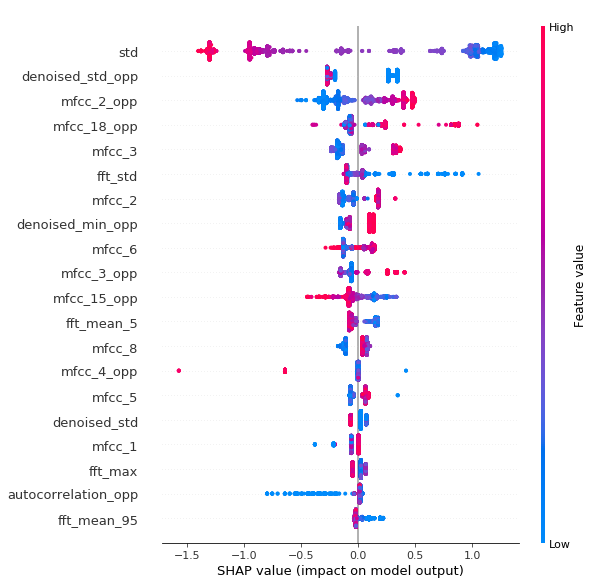

In [0]:

############# Most time taking function ############
##### Don't Run if less ram #########
import shap

explainer = shap.TreeExplainer(xgb_boost)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train)

# Stacking Models 


In [0]:
original_cv = []
for values in y_cv_org:
  original_cv.append(values[0])

In [0]:
#catboost prediction  
cat_arr = cat_model.predict(x_cv)  # best cv score 5.96480534
#lgbm
lgbm_arr = lgbm_model.predict(x_cv)  # best cv score 6.00064977
#XG boost
xgb_pred_cv = xgb_boost.predict(x_cv)  # best cv score 6.15943022
#random forest
rf_arr = rf_model.predict(x_cv)  # best cv score 6.18789375


res_list = [] 
# best is cat 
for i in range(0, len(cat_arr)): 
    res_list.append((((cat_arr[i]) * 0.8) + ((lgbm_arr[i])* 0.1)  + (xgb_pred_cv[i] * 0.05) + (rf_arr[i] * 0.05)))
  

In [387]:
#Check MAE on CV using all 4 models
# res_list is the predicted values
stack_result_cv = []
for index in range(0,len(res_list)):
  stack_result_cv.append((res_list[index] - original_cv[index]) * (res_list[index] - original_cv[index]))

sum_stack_cv = sum(stack_result_cv)

sum_stack_mean_cv = sum_stack_cv / len(res_list)
print(sum_stack_mean_cv)

# 5.88478023613998 on cat 0.5 lgbm 0.2 xgb 0.2 rf 0.1
# 5.960521842132663 on 0.25 all 
# 5.906810735767607 on cat 0.7 lgbm 0.25 xgb 0.15 rf 0.2
# 5.838706569077672 on cat 0.8 lgbm 0.1 xgb 0.05 rf 0.05

5.881337367701245


<b> <i>after stacking am getting "MAE" on cv is 5.8813 </b> </i>

# Predictions for test data

In [0]:
#catboost prediction  
cat_arr = cat_model.predict(x_test)  # best cv score 5.96480534
#lgbm
lgbm_arr = lgbm_model.predict(x_test)  # best cv score 6.00064977
#XG boost
xgb_pred_cv = xgb_boost.predict(x_test)  # best cv score 6.15943022
#random forest
rf_arr = rf_model.predict(x_test)  # best cv score 6.18789375


res_list = [] 
# best is cat 
for i in range(0, len(cat_arr)): 
    res_list.append((((cat_arr[i]) * 0.75) + ((lgbm_arr[i])* 0.1)  + (xgb_pred_cv[i] * 0.1) + (rf_arr[i] * 0.05)))
  

In [0]:
data = pd.read_csv('sample_submission.csv')

In [0]:
data['time_to_failure'] = res_list

In [0]:
data.to_csv('sample_submission_final_.csv')